In [1]:
# first use the standard method to compute the statistics
# by using the data already computed in KUIAS for two hours

import sys
sys.path+=['/Users/lunzhang/anaconda3/lib/python3.6/site-packages']
import DSGRN
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Counting method

In [4]:
def NetworkSpecStr(net_spec):
    net_spec_str = ""

    spec = "SOX17 : "
    activators = ' + '.join([ 'Y' + str(j) for j in range(0,2) if net_spec[j] == 1])
    repressors = ')('.join([ '~Y' + str(j) for j in range(0,2) if net_spec[j] == -1])
    if activators:
        activators = '(' + activators + ')'
    if repressors:
        repressors = '(' + repressors + ')'
    spec += activators + repressors + "\n "
    spec = spec.replace("Y0", "TAFP2C")
    spec = spec.replace("Y1", "ID1")
    net_spec_str += spec

    spec = "TAFP2C : "
    activators = ' + '.join([ 'Y' + str(j) for j in range(2,5) if net_spec[j] == 1])
    repressors = ')('.join([ '~Y' + str(j) for j in range(2,5) if net_spec[j] == -1])
    if activators:
        activators = '(' + activators + ')'
    if repressors:
        repressors = '(' + repressors + ')'
    spec += activators + repressors + "\n "
    spec = spec.replace("Y2", "HAND1")
    spec = spec.replace("Y3", "ID1")
    spec = spec.replace("Y4", "SOX17")
    net_spec_str += spec

    spec = "PRDMI : " + ("~SOX17" if net_spec[5] == -1 else "SOX17") + "\n "
    net_spec_str += spec

    spec = "HAND1 : " + ("~PRDMI" if net_spec[6] == -1 else "PRDMI") + "\n "
    net_spec_str += spec

    spec = "ID1 : " + ("~PRDMI" if net_spec[7] == -1 else "PRDMI")
    net_spec_str += spec

    return net_spec_str

In [5]:
pwd

'/Users/lunzhang/Desktop/autoDesign'

In [6]:
results = []
for k in range(256):
    results_fname = './DSGRNtest/results/results_' + str(k) + '.txt'
    with open(results_fname, 'r') as f:
        results.append([k] + [int(float(x)) for line in f for x in line.split()])

In [7]:
innw = {'SOX17':['ID1','TAFP2C'], 
        'TFAP2C':['ID1','SOX17','HAND1'],'PRDMI':['SOX17'],'HAND1':['PRDMI'],'ID1':['PRDMI']}
setnodes = ['SOX17','TFAP2C','PRDMI','HAND1','ID1']
regions = [[0,0,0,0,0],[2,1,2,0,2]]

In [8]:
network_specs = []
for k in range(256):
    net_spec_fname = './DSGRNtest/results/net_spec_' + str(k) + '.txt'
    with open(net_spec_fname, 'r') as f:
        network_specs.append([int(k) for line in f for k in line.split()])

In [9]:
# results.sort(key=lambda x: x[2]+x[3]-x[4], reverse=True)
results.sort(key=lambda x: x[4], reverse=True)

In [10]:
results[:5]

[[221, 345600, 14112, 38304, 936, 41],
 [223, 345600, 28224, 19152, 936, 47],
 [253, 345600, 19152, 28224, 936, 35],
 [255, 345600, 38304, 14112, 936, 44],
 [205, 345600, 6048, 28224, 216, 36]]

In [11]:
936/345600

0.0027083333333333334

In [12]:
k=0
(results[k][3] / results[k][1]) * 100

11.083333333333334

In [13]:
spec_index = 221
net_spec = network_specs[spec_index]
net_spec_str = NetworkSpecStr(net_spec)
net_spec_str

'SOX17 : (TAFP2C + ID1)\n TAFP2C : (ID1 + SOX17)(~HAND1)\n PRDMI : SOX17\n HAND1 : ~PRDMI\n ID1 : PRDMI'

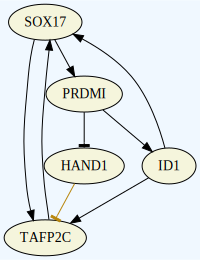

In [14]:
k = 0
spec_index = results[k][0]
net_spec = network_specs[spec_index]
net_spec_str = NetworkSpecStr(net_spec)
network = DSGRN.Network(net_spec_str)

DSGRN.DrawGraph(network)

# Conjugate method ( All LU equilibrim)

In [13]:
from stableStatistics import *

In [18]:
nw = 'nw.txt'
istates = {'SOX17':'L', 'PRDMI':'L', 'HAND1':'L', 'ID1':'L','TAFP2C':'L'}
conj = computetotalprop(nw,istates)*100

print('Conjugate method: {}'.format(conj))

Couting method: 4.083333333333333
Conjugate method: 4.083333333333332


In [13]:
# generate all L,H equilibrium states
nodeList = list(istates.keys())
allstates = generateAllLUStates(nodeList)
print(len(allstates))

# generate all index of direct product structure
# ret is always a set of direct product set
# those set may not be disjoint
ret = []
for istates in allstates:
    conj = gettotalindex(nw,istates)
    ret.append(conj)

32
